# Complex Networks Data Visualization
Analysis of a [Scale-Free network](https://en.wikipedia.org/wiki/Scale-free_network) based on preferential attachment with a focus on <b>VISUALIZING</b> interesting results.

### Import libraries

In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm # community detection algorithms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import math
from scipy import stats # to do regression for the estimation of the exponent

## Create the Network


A typical behaviour in real word Complex Networks, and in particular in those related to human relationships and contacts, is the <b>preferential attachment</b> mechanism. <br>

<b>Preferential attachment</b> means that the more connected a node is (e.g. the more contacts a person has), the more likely it is to receive new links. Nodes with higher degree have stronger ability to attract links added to the network.
These kind of networks are characterized by a nodes degree distribution containing a very long tale. They are also called Scale-Free (SF) networks; some examples are: social networks, computer networks, protein-protein interaction networks...

In our case, we consider the <b>Barabasi-Albert (BA)</b> model which is an algorithm for generating random SF networks using the preferential attachment mechanism.
It is based on two main principles:
* <i>Network growth</i>: the size of the network is increased starting from an initial number of nodes by incrementally adding new nodes each one with a fixed number of edges.
* <i>Preferential attachment</i>: new nodes are connected to the existing nodes according to the idea of preferential attachment, i.e. more connected nodes have more probability to attract new nodes. <br>

The BA algorithm is already implemented by the [barabasi_albert_graph()](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html) function of Networkx

### Implementation of the BA algorithm
We'll manualy implement the BA algorithm (for creating a SF network) in order to show how the preferential attachment mechanism works in detail. <br>
The Python implementation of the algorithm, by using Lists data structures and the Networkx functions is very heavy: in order to improve the performance of the algorithm, we decided to use the [Cython](https://cython.org/) extension, which allows to use C static compiling inside the Python code.

In [2]:
!pip install Cython

Be sure to install Cython extension

In [3]:
# import cython module for allowing C compilation and static binding
%load_ext Cython

#### Parameters
The algorithm has 3 input parameters: 
* n_0: number of initial nodes
* N: number of final nodes
* m: number of links for each new added node (should be m < m_0)

In [4]:
n_0 = 20
N = 500
m = 3

Let's now create the initial graph: we build a complete graph with n_0 nodes:

In [5]:
G = nx.complete_graph(n_0)

In [6]:
len(G.nodes())

20

In [7]:
# list the nodes
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

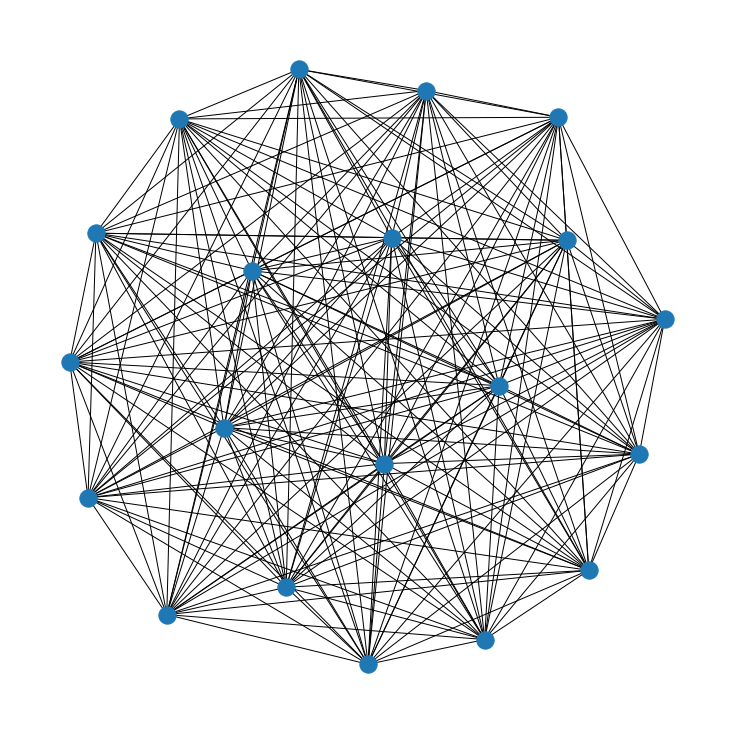

In [8]:
plt.rcParams["figure.figsize"] = (10, 10)

# Visualize the graph
nx.draw(G, node_size=300)

The plot above clearly shows the structure of a COMPLETE graph, i.e. a graph in which each node is connected to every other node.

We now need to incrementally add nodes until reaching N (we'll add nodes by increasing the number/label identifying each node). 
We use a loop to do that. After adding a node we need to add m links from it to the existing nodes, we'll use another (nested) loop to do that.

#### Auxiliary functions

Before implementing the actual code of the algorithm, lets define some helper functions for creating m links between the newly added node and the existing nodes according to the preferential attachment mechanism.

The first function we'll define builds the weighted probabilities of the graph nodes. <br>
Since this function is very expensive and it needs to be called at each inserted node during the execution of the BA algorithm, we declare it as a C function and we add also some static binding for some of the used variables. <br>
In this way we greatly improve the performance of the algorithm even when generating networks of big size.

In [9]:
%%cython
import numpy as np
import networkx as nx

# returns the list of the weighted probability of each existing node
def build_probs(G):
    nodes_probs = [] # our list
    
    # static variables
    cdef int node_deg
    cdef double node_prob
    cdef double degrees_sum = 2 * len(G.edges) # N.B.: 2 * len(G.edges) returns the sum of the degrees of all the nodes, since each edge contributes to the degree of 2 nodes
                                     
    # compute the probability for each node
    for node in G.nodes():
        node_deg = G.degree(node)
        
        # probability of the node
        node_prob = node_deg / degrees_sum 
        
        # insert into the list
        nodes_probs.append(node_prob)
    
    return nodes_probs

The 2nd auxiliary function adds m links between a node and the existing nodes, according to the preferential attachment.
We use the random.choice() function of the numpy module, which takes as input the list of nodes among which to select one and the probability associated to each node.

In [10]:
def add_links(G, added_node):
    selected_nodes = [] # list of the selected nodes
    
    # before inserting the links we build the weighted probabilities of each node
    nodes_probs = build_probs(G)
    
    # add m links
    for added_links in range(m):   
        # we use the choice function of the numpy.random module
        selected_node = np.random.choice(G.nodes(),p=nodes_probs) # selects a node according to preferential attachment
        
        # check whether the node was already selected (to avoid multiple links)
        while selected_node in selected_nodes:
            selected_node = np.random.choice(G.nodes(),p=nodes_probs) # select another node
        
        selected_nodes.append(selected_node)
        
        # once we selected the node we should create the link among the added_node given as a parameter
        # and the selected_node
        G.add_edge(added_node, selected_node)
        

#### Algorithm

In [11]:
nodes_to_add = N - n_0 # number of nodes to add until reaching N total nodes
inserted_nodes = 0 # counter of the inserted nodes

start_time = time.time()

for n_i in range(nodes_to_add):
     
    # insert new_node in the graph
    print("--------------- STEP: {} ---------------".format(inserted_nodes + 1))
    G.add_node(n_0 + inserted_nodes) # we add the node by specifying its numeric value (starting from 50)
    added_node = n_0 + inserted_nodes # identifier of the added node
    inserted_nodes += 1
    
    print("Node added: {}".format(added_node))
    # add the newly inserted node into nodes_probs because of the random.choice function to work
    
    # --------------------------------------------------------------

    # after adding the node, we need to create m links with the existing nodes 
    # according to the preferential attachment mechanism
    
    # function to add m links to the newly inserted node
    add_links(G, added_node)

elapsed_time = time.time() - start_time

--------------- STEP: 1 ---------------
Node added: 20
--------------- STEP: 2 ---------------
Node added: 21
--------------- STEP: 3 ---------------
Node added: 22
--------------- STEP: 4 ---------------
Node added: 23
--------------- STEP: 5 ---------------
Node added: 24
--------------- STEP: 6 ---------------
Node added: 25
--------------- STEP: 7 ---------------
Node added: 26
--------------- STEP: 8 ---------------
Node added: 27
--------------- STEP: 9 ---------------
Node added: 28
--------------- STEP: 10 ---------------
Node added: 29
--------------- STEP: 11 ---------------
Node added: 30
--------------- STEP: 12 ---------------
Node added: 31
--------------- STEP: 13 ---------------
Node added: 32
--------------- STEP: 14 ---------------
Node added: 33
--------------- STEP: 15 ---------------
Node added: 34
--------------- STEP: 16 ---------------
Node added: 35
--------------- STEP: 17 ---------------
Node added: 36
--------------- STEP: 18 ---------------
Node added: 37
-

--------------- STEP: 277 ---------------
Node added: 296
--------------- STEP: 278 ---------------
Node added: 297
--------------- STEP: 279 ---------------
Node added: 298
--------------- STEP: 280 ---------------
Node added: 299
--------------- STEP: 281 ---------------
Node added: 300
--------------- STEP: 282 ---------------
Node added: 301
--------------- STEP: 283 ---------------
Node added: 302
--------------- STEP: 284 ---------------
Node added: 303
--------------- STEP: 285 ---------------
Node added: 304
--------------- STEP: 286 ---------------
Node added: 305
--------------- STEP: 287 ---------------
Node added: 306
--------------- STEP: 288 ---------------
Node added: 307
--------------- STEP: 289 ---------------
Node added: 308
--------------- STEP: 290 ---------------
Node added: 309
--------------- STEP: 291 ---------------
Node added: 310
--------------- STEP: 292 ---------------
Node added: 311
--------------- STEP: 293 ---------------
Node added: 312
--------------

--------------- STEP: 441 ---------------
Node added: 460
--------------- STEP: 442 ---------------
Node added: 461
--------------- STEP: 443 ---------------
Node added: 462
--------------- STEP: 444 ---------------
Node added: 463
--------------- STEP: 445 ---------------
Node added: 464
--------------- STEP: 446 ---------------
Node added: 465
--------------- STEP: 447 ---------------
Node added: 466
--------------- STEP: 448 ---------------
Node added: 467
--------------- STEP: 449 ---------------
Node added: 468
--------------- STEP: 450 ---------------
Node added: 469
--------------- STEP: 451 ---------------
Node added: 470
--------------- STEP: 452 ---------------
Node added: 471
--------------- STEP: 453 ---------------
Node added: 472
--------------- STEP: 454 ---------------
Node added: 473
--------------- STEP: 455 ---------------
Node added: 474
--------------- STEP: 456 ---------------
Node added: 475
--------------- STEP: 457 ---------------
Node added: 476
--------------

In [12]:
print("Time required: {} seconds, {} minutes".format(elapsed_time, elapsed_time/60))

Time required: 0.44383740425109863 seconds, 0.007397290070851644 minutes


#### Save the network

In [13]:
nx.write_pajek(G, "BA_net.net")

## Exploratory analysis
In order to better understand the network we just loaded, let's analyze some general characteristics of the net. 

In [14]:
print(G.nodes())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [15]:
print(G.edges)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 21), (0, 27), (0, 29), (0, 35), (0, 54), (0, 67), (0, 83), (0, 93), (0, 96), (0, 101), (0, 102), (0, 103), (0, 115), (0, 117), (0, 148), (0, 184), (0, 185), (0, 207), (0, 209), (0, 215), (0, 230), (0, 238), (0, 242), (0, 244), (0, 253), (0, 262), (0, 265), (0, 291), (0, 301), (0, 325), (0, 326), (0, 338), (0, 348), (0, 355), (0, 390), (0, 395), (0, 402), (0, 411), (0, 420), (0, 427), (0, 428), (0, 460), (0, 464), (0, 479), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 23), (1, 24), (1, 52), (1, 54), (1, 59), (1, 61), (1, 70), (1, 82), (1, 86), (1, 88), (1, 105), (1, 121), (1, 131), (1, 136), (1, 141), (1, 148), (1, 218), (1, 221), (1, 224), (1, 238), (1, 266), (1, 267), (1, 272), (1, 296), (1, 365), (1,

### Network Descriptors
Let's calculate some of the most representative properties of the network. <br>

All the methods used in order to perform the calculations are implemented in the networkx library

In [16]:
print("Number of nodes: {}".format(G.number_of_nodes()))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
#G = nx.Graph(G)

print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
if nx.is_connected(G):
    print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
    print("Diameter: {}".format(nx.diameter(G)))

Number of nodes: 500
Number of edges: 1630
Min degree: 3
Max degree: 67
Avg degree: 6.52
Clustering: 0.1589
Assortativity: -0.0285
Avg path length: 2.9177
Diameter: 5


### Plot the net
At first, let's try to plot the network, even if the visualization will be difficult due to the high number of edges and nodes.<br>
In order to obtain a clearer plot we will use the layout algorithm proposed by Kamada-Kawai which renders the network with minimal edge-overlapping.<br>
Original paper: https://doi.org/10.1016/0020-0190(89)90102-6<br> <br>
This will allow us to use always the same positioning for the nodes in all the plots we'll perform.

In [17]:
pos = nx.kamada_kawai_layout(G)

We use the Networkx [draw()](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw) function, which takes in input also the positioning of the nodes (the one we obtained by applying Kamada-Kawai nodes positioning): 

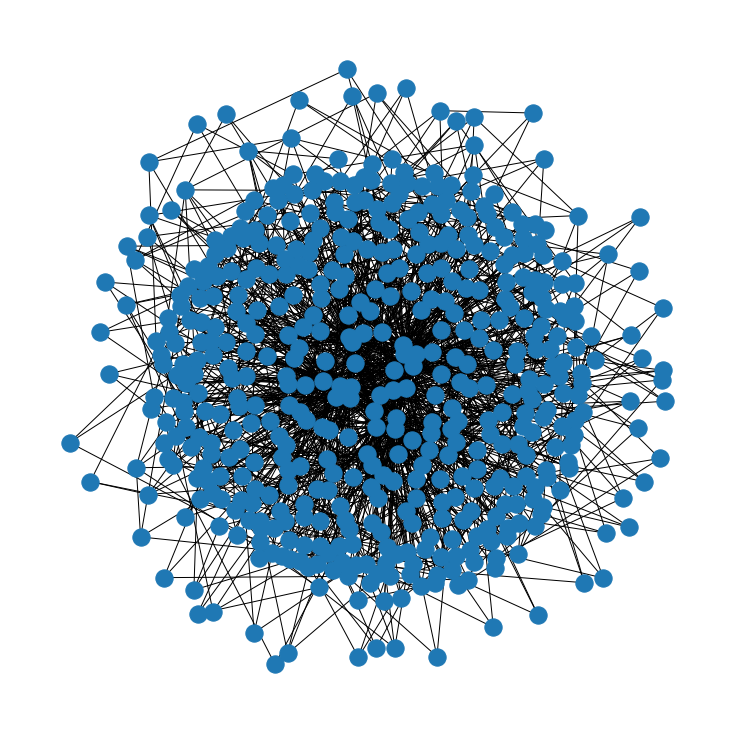

In [18]:
nx.draw(G, pos=pos)

To improve the above plot, we can try to reduce the size of the nodes, the width of the edges and we can also use a lighter colour for the edges, instead of the standard black:

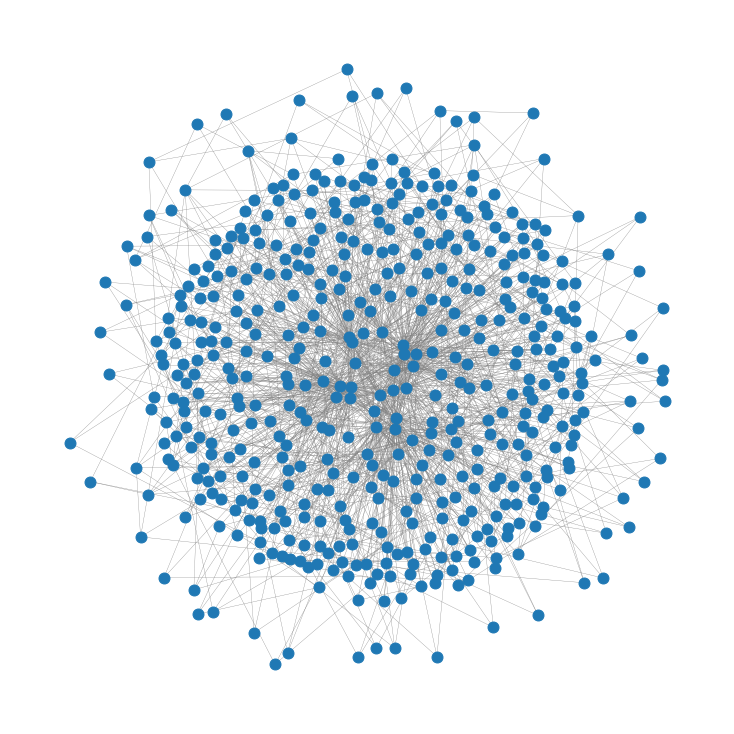

In [19]:
nx.draw(G, pos=pos, node_size=120, width=0.3, edge_color='0.5')

An interesting visualization can be obtained by plotting the nodes with a size depending on the degree: in this way we can visualize the 'sink' nodes, typical of a SF network:

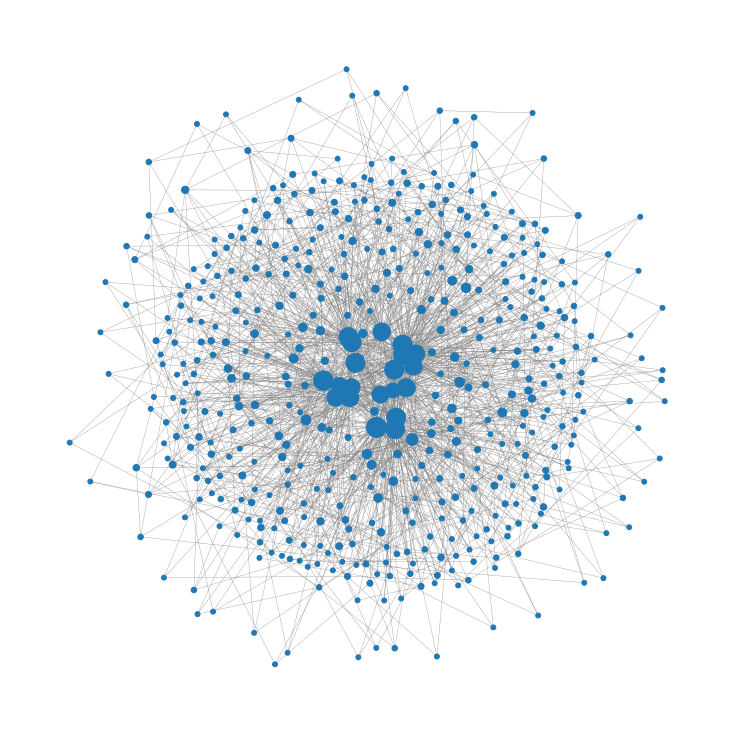

In [20]:
d = dict(G.degree) # dictionary with the degree of each node

nx.draw(G, pos=pos, node_size=[(v + 1) * 6 for v in d.values()], width=0.3, edge_color='0.5') # v + 1 to show also nodes with zero degree

As it is shown from the plot above, the network is characterized by a very few nodes with an high degree, while the majority of the nodes is characterized by very low degree values. <br>
This is a the typical behaviour in a SF network and, in particular, in a network build by following the preferential attachment mechanism.<br><br>
We can also visualize the labels of the nodes, in order to directly see which are the ones with the highest degree:

In [21]:
degree_values = list(d.values())
degree_values.sort(reverse=True)
tsh = degree_values[30] # keep first 30 'sink' nodes

sel_nodes = [n for n,v in d.items() if v > tsh] # list of 'sink' nodes

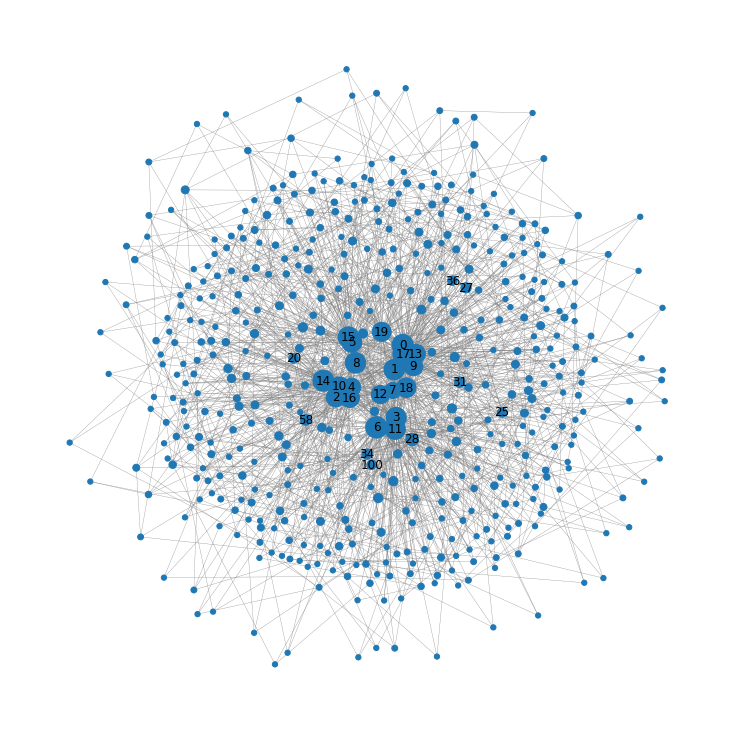

In [22]:
nodes_list = list(G.nodes())

# we create a dictionary with the labels of the nodes with a degree higher than tsh
labels = {
    n: (nodes_list[n]
        if  d[n] > tsh
        else '')
    for n in G.nodes
}

# show lables only in the 'sink' nodes
nx.draw(G, pos=pos, node_size=[(v + 1) * 7 for v in d.values()], width=0.3, edge_color='0.5', with_labels=True, labels=labels)

An alternative way to visualize 'sink' nodes could be to plot only them with all the links:

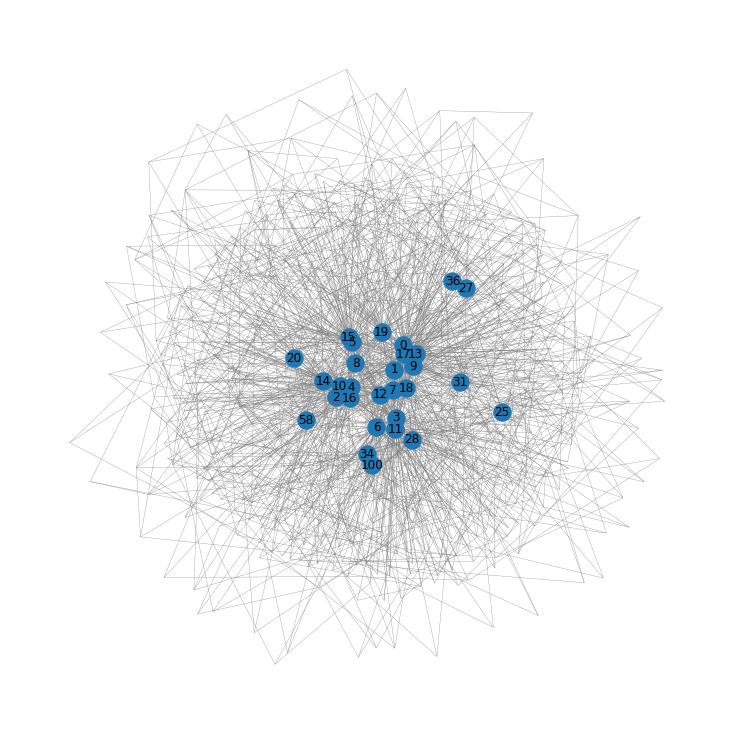

In [23]:
nx.draw(G, pos=pos, nodelist= sel_nodes, width=0.3, edge_color='0.5', with_labels=True, labels=labels)

We could mantain only the edges among 'sink' nodes in order to see the links among them, in that way we are plotting the subgraph composed by them:

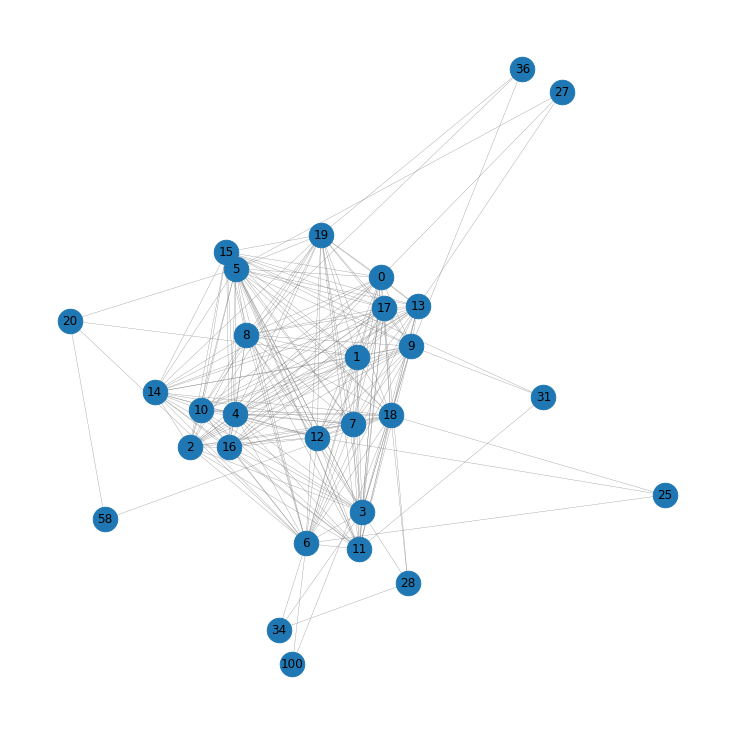

In [24]:
subG = G.subgraph(sel_nodes)
nx.draw(subG, pos=pos, nodelist= sel_nodes, width=0.3, edge_color='0.5', node_size = 600, with_labels=True, labels=labels)

An alternative approach to obtain some useful insights is to plot the nodes with the highest [betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality), i.e. nodes that are traversed by a lot of shortest paths among pair of other nodes in the network:

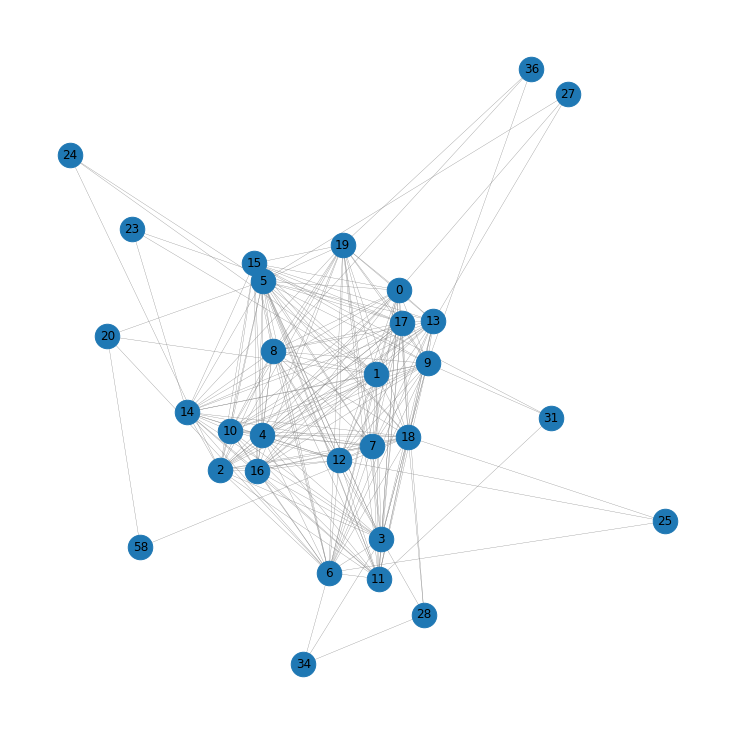

In [25]:
centr = nx.betweenness_centrality(G) # dictionary with the betweenness centrality of each node

values = list(centr.values())
values.sort(reverse=True)
tsh = values[30] # keep 30 most central nodes

sel_nodes = [n for n,v in centr.items() if v > tsh]

# we create a dictionary with the labels of the nodes with a degree higher than tsh
labels = {
    n: (nodes_list[n]
        if  centr[n] > tsh
        else '')
    for n in G.nodes
}

# Let' s plot the most central nodes, according to the betweenness centrality
subG = G.subgraph(sel_nodes)
nx.draw(subG, pos=pos, nodelist= sel_nodes, width=0.3, edge_color='0.5', node_size = 600, with_labels=True, labels=labels)

Notice that the position of the nodes in all the plots we performed is always the same (same coordinates), since we fixed the coordinates by using the Kamada-Kawai algorithm, and we always use that positioning in the draw() function.

### Degree distribution histograms
SF networks are characterized by a powerlaw degree distributions, where the nodes degree probability follows the equation:  P(k) = k<sup>-$\gamma$	</sup>, where k denotes the degree value and P(k) denotes the percentage of nodes with a degree equal to k. <br> <br>
It may be useful to visualize the degree distribution by using histograms. 
In this case we'll plot the histograms of the degree distributions (PDF, probability distribution function) and the complementary cumulative degree distributions (CCDF).<br>
Since the network is characterized by a powerlaw degree distribution, with a very long tail, we'll perform the plots both in linear and in log-log scale.<br><br>
Let's define some auxiliary functions for plotting these histograms:

In [26]:
# Auxiliary function to create logaritmically spaced bins (for log-log histogram) by specifying the number of bins
def create_log_bins(degrees, num = 15):
    bins = np.logspace(np.log10(np.min(degrees)), np.log10(np.max(degrees)), num)
    bins = np.array(bins)
    return bins

In [27]:
plt.style.use('ggplot')

In [28]:
# PDF histogram in linear scale
def plot_linear_PDF(G, nbins = 15):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.title('PDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = False)
    plt.tight_layout()
    plt.style.use('ggplot')

In [29]:
# PDF histogram in Log-Log scale
def plot_loglog_PDF(G, nbins=15):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num = nbins)
    
    plt.title('PDF in log-log scale',  fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = False)
    plt.tight_layout()
    plt.style.use('ggplot')

In [30]:
# CCDF histogram in linear scale
def plot_linear_CCDF(G, nbins=15):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.title('CCDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = -1)
    plt.tight_layout()
    plt.style.use('ggplot')

In [31]:
# CCDF histogram in Log-Log scale
def plot_loglog_CCDF(G, nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num=nbins)
    
    plt.title('CCDF in log-log scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = -1)
    plt.tight_layout()
    plt.style.use('ggplot')

In [32]:
# CCDF histogram in Log-Log scale
def plot_loglog_CCDF(G, nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num=nbins)
    
    plt.title('CCDF in log-log scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = -1)
    plt.tight_layout()
    plt.style.use('ggplot')

In [33]:
# number of bins to use
n_bins = 10

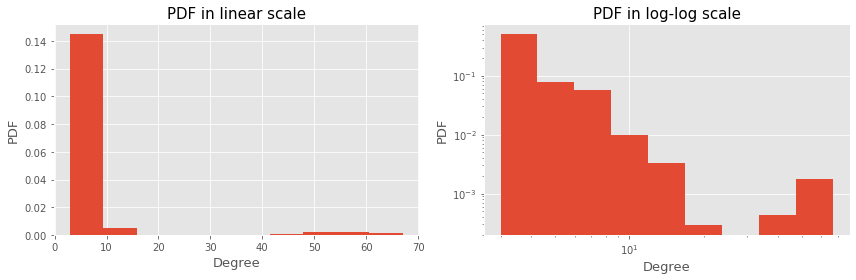

In [34]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_PDF(G, nbins=n_bins) 
plt.subplot(1, 2, 2)
plot_loglog_PDF(G, nbins=n_bins)
plt.show()

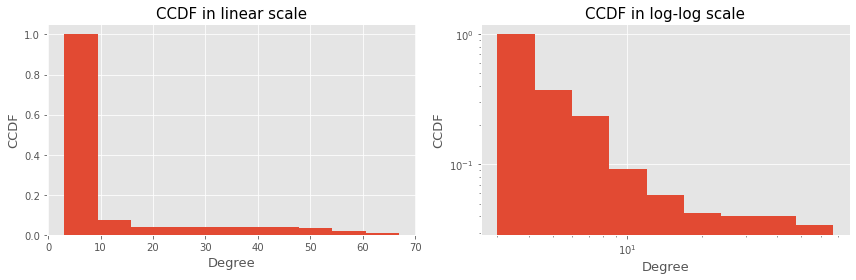

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_CCDF(G, nbins=n_bins) 
plt.subplot(1, 2, 2)
plot_loglog_CCDF(G, nbins=n_bins)
plt.show()

### Estimation of the exponent for the empirical degree distribution
In case of a scale-free network, i.e. a network following a powerlaw degree distribution (as
the ones generated by a BA model), we may be interested in estimating the exponent of the
empirical power-law distribution.

We'll see 3 main approaches for estimating the exponent of a scale-free network:
* MLE
* Linear regression on the binned PDF histogram
* Linear regression on the binned CCDF histogram

Let's see these three approaches and then we'll compare the results obtained by each one of them

#### Using MLE
* We can use the <i>powerlaw</i> Python package described here: https://arxiv.org/abs/1305.0215, which is based on a MLE of the exponent of a powerlaw distribution . <br>
As described in the paper https://arxiv.org/abs/0706.1062, the <i>powerlaw</i> package performs the exponent estimation by following the formula 3.7 of the paper. <br>
According to the paper, the first step to perform a maximum likelihood fit to a powerlaw is to determine what portion of the data to fit. A heavy-tailed
distribution's interesting feature is, indeed, the tail and its properties, so if the initial, small values of the data
do not follow a power law distribution we may opt to disregard them. The question is from what
minimal value xmin (Kmin) the scaling relationship of the power law begins. The methods described in the paper of Clauset et al. mentioned above find this optimal value of xmin by creating a powerlaw fit starting from each unique value in the dataset, then selecting the one that results in the minimal Kolmogorov-Smirnov distance, D, between the data and the fit. Therefore the algorithm finds xmin my minimizing D. <br> <br>
* While the maximum likelihood fit to a continous power law can be calculated analytically,
and thus the optimal xmin and resulting fitted parameters can be computed quickly, this is not so for the discrete case. The maximum likelihood fit for a discrete power law is found by numerical optimization,
the computation of which for every possible value of xmin can take time. To circumvent this issue,
powerlaw can use an analytic estimate of gamma, from [https://arxiv.org/abs/0706.1062], which can "give results accurate to about 1% or
better provided xmin ≥ 6".




In [36]:
!pip install powerlaw

In [37]:
import powerlaw

degrees = [G.degree(n) for n in G.nodes()]
results = powerlaw.Fit(degrees, discrete = True)
print("\n\nExponent estimation:")
print(round(results.power_law.alpha, 4))
#print(results.power_law.xmin)

Calculating best minimal value for power law fit
xmin progress: 96%

Exponent estimation:
2.6422


#### Using Linear Regression

In [38]:
# find min and max of the degrees
Kmin = np.min(degrees)
Kmax = np.max(degrees)

Kmin, Kmax

(3, 67)

In [39]:
# calculate the logarithm of K_i for all the data elements
log_degrees = [np.log10(G.degree(n)) for n in G.nodes()]
#log_degrees

In [40]:
# calculate useful logs
log_Kmin = np.log10(Kmin)
#log_Kmax = np.log10(Kmax)
log_Kmax_1 = np.log10(Kmax + 1)
log_Kmin, log_Kmax_1

(0.47712125471966244, 1.8325089127062364)

Divide the interval in equal size bins and build the bins

In [41]:
# length of the interval
interval_length = (log_Kmax_1 - log_Kmin) / n_bins

# build the bins
bins = []
for i in range(n_bins):
    bins.append(log_Kmin + interval_length * i)
bins.append(log_Kmax_1)
bins

[0.47712125471966244,
 0.6126600205183198,
 0.7481987863169772,
 0.8837375521156345,
 1.019276317914292,
 1.1548150837129494,
 1.2903538495116067,
 1.4258926153102642,
 1.5614313811089215,
 1.6969701469075789,
 1.8325089127062364]

In [42]:
# Count how many elements ki have their log(ki) in each bin
counts = []
for i in range(n_bins):
    counts.append(len([deg for deg in log_degrees if deg >= bins[i] and deg < bins[i+1]]))

counts

[315, 68, 49, 33, 12, 2, 1, 1, 4, 15]

In [43]:
# Dividing the number of elements in each bin by the total number of elements n we get estimations for the probabilities p_b of each bin
probs = [deg/ N for deg in counts]
probs # probabilities of each bin

[0.63, 0.136, 0.098, 0.066, 0.024, 0.004, 0.002, 0.002, 0.008, 0.03]

In [44]:
np.sum(probs)

1.0

### Linear regression on the PDF

We now need to make the linear regression of pairs (x_b, log_pb) to obtain the regression line. <br>
Let's first calculate the elements of log_pb


In [45]:
log_PDF_p = [np.log10(p) for p in probs]
log_PDF_p

[-0.2006594505464183,
 -0.8664610916297825,
 -1.0087739243075051,
 -1.1804560644581312,
 -1.6197887582883939,
 -2.3979400086720375,
 -2.6989700043360187,
 -2.6989700043360187,
 -2.0969100130080562,
 -1.5228787452803376]

We may have some infinite values: let's remove them from the list

In [46]:
# list containing indices of the infinite elements
inf_indices = []

# populate the list
for i in range(len(log_PDF_p)):
    if math.isinf(log_PDF_p[i]):
        inf_indices.append(i)
               
inf_indices

[]

In [47]:
# select only finite elements:
log_PDF_p = [v for v in log_PDF_p if not math.isinf(v)]
log_PDF_p

[-0.2006594505464183,
 -0.8664610916297825,
 -1.0087739243075051,
 -1.1804560644581312,
 -1.6197887582883939,
 -2.3979400086720375,
 -2.6989700043360187,
 -2.6989700043360187,
 -2.0969100130080562,
 -1.5228787452803376]

The X vector of the linear regression is the bins vector, except from the first element <br>

In [48]:
X = bins[1:]

# we should select only elements corresponding to finite values of the correspondig log_PDF_p
x_2 = []
for i in range(len(X)):
    if i not in inf_indices:
        x_2.append(X[i])
X = x_2
X

[0.6126600205183198,
 0.7481987863169772,
 0.8837375521156345,
 1.019276317914292,
 1.1548150837129494,
 1.2903538495116067,
 1.4258926153102642,
 1.5614313811089215,
 1.6969701469075789,
 1.8325089127062364]

The Y vector of the linear regression is log_PDF_pLog_pb

In [49]:
Y = log_PDF_p
Y

[-0.2006594505464183,
 -0.8664610916297825,
 -1.0087739243075051,
 -1.1804560644581312,
 -1.6197887582883939,
 -2.3979400086720375,
 -2.6989700043360187,
 -2.6989700043360187,
 -2.0969100130080562,
 -1.5228787452803376]

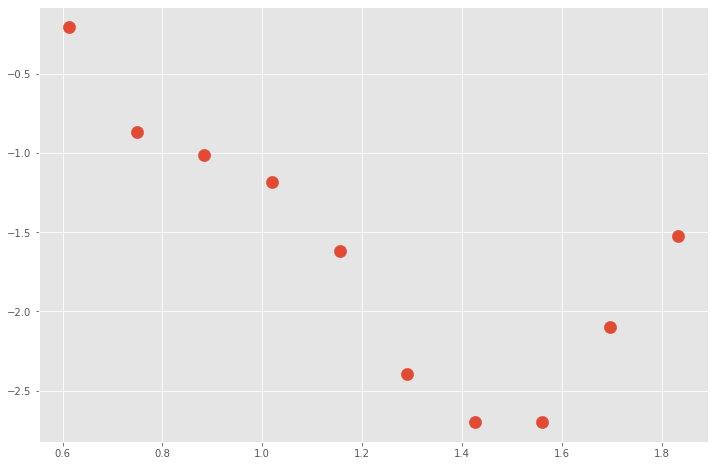

In [50]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(X, Y, s=150)
plt.show()

Let's perform the Linear Regression by using the stats function of the scipy package

In [51]:
regr = stats.linregress(X, Y)

We are interested in the slope of the regression line, indeed the estimation of the exponent is: <br>
* gamma = -slope + 1

In [52]:
print("Slope: ", regr.slope)
exponent_estimation =  - regr.slope + 1
print("\nExponent estimation:", exponent_estimation)

Slope:  -1.5336231676828285

Exponent estimation: 2.5336231676828285


### Linear regression on the CCDF

Another alternative for the estimation of exponent gamma consists in doing exactly the same as above but for the complementary cumulative distribution function (CCDF) instead of the probability density function (PDF). <br>
CCDF is calculated from the PDF just by summing up 
the probabilities of all the bins to the right of the bin you are considering (this one included in the sum). 

In [53]:
# probabilities of the bins
probs

[0.63, 0.136, 0.098, 0.066, 0.024, 0.004, 0.002, 0.002, 0.008, 0.03]

In [54]:
# compute CCDF by summing on the right
CCDF_c = []
for i in range(len(probs)):
    CCDF_c.append(np.sum(probs[i:]))

In [55]:
CCDF_c

[1.0,
 0.37,
 0.23399999999999999,
 0.136,
 0.07,
 0.046,
 0.041999999999999996,
 0.04,
 0.038,
 0.03]

We now need to make the linear regression of pairs (x_b and log_pb) to obtain the regression line.<br>
Let's first calculate the elements of log(cb)

In [56]:
log_CCDF_c = [np.log10(c) for c in CCDF_c]
log_CCDF_c

[0.0,
 -0.431798275933005,
 -0.6307841425898572,
 -0.8664610916297825,
 -1.154901959985743,
 -1.337242168318426,
 -1.3767507096020997,
 -1.3979400086720375,
 -1.4202164033831899,
 -1.5228787452803376]

Again, as before, we may have infinite values that we should remove

In [57]:
# list containing indices of the infinite elements
inf_indices = []

for i in range(len(log_CCDF_c)):
    if math.isinf(log_CCDF_c[i]):
        inf_indices.append(i)
               
inf_indices

[]

In [58]:
# select only finite elements:
log_CCDF_c = [v for v in log_CCDF_c if not math.isinf(v)]
log_CCDF_c

[0.0,
 -0.431798275933005,
 -0.6307841425898572,
 -0.8664610916297825,
 -1.154901959985743,
 -1.337242168318426,
 -1.3767507096020997,
 -1.3979400086720375,
 -1.4202164033831899,
 -1.5228787452803376]

X vector is the bins vector, except from the first element <br>

In [59]:
X = bins[1:]

# we should select only elements corresponding to finite values of the correspondig log_PDF_p
x_2 = []
for i in range(len(X)):
    if i not in inf_indices:
        x_2.append(X[i])
X = x_2
X

[0.6126600205183198,
 0.7481987863169772,
 0.8837375521156345,
 1.019276317914292,
 1.1548150837129494,
 1.2903538495116067,
 1.4258926153102642,
 1.5614313811089215,
 1.6969701469075789,
 1.8325089127062364]

Y vector is the log_CCDF_c vector computed above

In [60]:
Y = log_CCDF_c

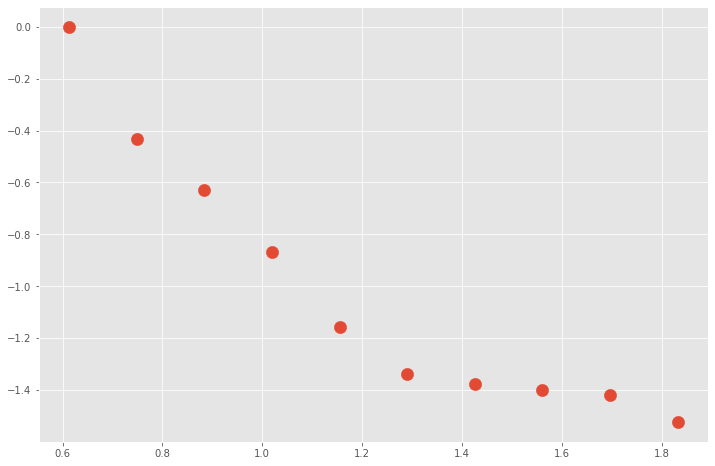

In [61]:
plt.scatter(X, Y, s=150)
plt.show()

Let's perform the Linear Regression by using the stats function of the scipy package: the procedure is the same as before.

In [62]:
regr = stats.linregress(X, Y)
print("Slope: ", regr.slope)
exponent_estimation =  - regr.slope + 1
print("\nExponent estimation:", exponent_estimation)

Slope:  -1.1703606372867854

Exponent estimation: 2.1703606372867856


#### Conclusion on exponent estimation
The theoretical degree distribution of a Barabasi-Albert network follows a powerlaw with an exponent $\gamma$ set to 3 (for more information: https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model).<br>

Binning-based approaches, i.e. the 2 approaches we saw based on constructing bins and performing regression on the binned data,  perform poorly. <br>
As we can easily imagine, in binning-based approaches the estimated exponent is highly dependent on the choice of bin width (here we used a fixed number of 15 bins), and this dependency varies as a function of sample size (as can be seen in this [paper](https://www.researchgate.net/publication/5369140_On_estimating_the_exponent_of_power-law_frequency_distributions)). <br>
In general, binning results in a loss of
information about the distributions of points within a
bin and is thus expected to perform poorly. Therefore, while binning is
useful for visualizing the frequency distribution, binning-based approaches should be avoided for
parameter estimation (in this [paper](https://www.researchgate.net/publication/5369140_On_estimating_the_exponent_of_power-law_frequency_distributions) more details about this). <br>

Maximum likelihood estimation performs best in estimating the powerlaw exponent.

### Plot 

We can now plot the degree distribution in linear scale and in log-log scale, showing how the degree distribution of Barabási–Albert network gives a straight line in log-log scale since it follows th equation k<sup>-3</sup>, i.e. it is a powerlaw with exponent $\gamma$ set to 3. <br><br>
Let's define some auxiliary functions for performing the plots:

In [63]:
# Plot degrees probability distributions in linear scale
def plot_distrib_lin(graph, colour='#40a6d1', alpha=.8, expct_lo=1, expct_hi=10):
    num_nodes = graph.number_of_nodes()

    # Calculate the maximum degree to know the range of x-axis
    max_degree = np.max([val for key,val in graph.degree()])

    # X-axis and y-axis values
    x = []
    y_tmp = []

    # Loop over all degrees until the maximum to compute the portion of nodes for that degree
    for i in range(max_degree + 1):
        x.append(i) # build x list
        y_tmp.append(0) # build y list

        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i / num_nodes for i in y_tmp]

    plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)
    plt.title('Degree distribution (linear scale)')
    plt.ylabel('P(k)')
    plt.xlabel('k')
    plt.legend(["Real degrees"])

In [64]:
# Plot degrees probability distributions in log-log scale
def plot_distrib_log(graph, colour='#40a6d1', alpha=.8, fit_line=False, gam = 3,  expct_lo=1, expct_hi=10, expct_const=1):
    num_nodes = graph.number_of_nodes()

    # Calculate the maximum degree to know the range of x-axis
    max_degree = np.max([val for key,val in graph.degree()])

    # X-axis and y-axis values
    x = []
    y_tmp = []

    # Loop over all degrees until the maximum to compute the portion of nodes for that degree
    for i in range(max_degree + 1):
        x.append(i) # build x list
        y_tmp.append(0) # build y list

        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i / num_nodes for i in y_tmp]

    plt.xscale('log')
    plt.yscale('log')
    plt.title('Degree distribution (log-log scale)')
    plt.ylabel('log(P(k))')
    plt.xlabel('log(k)')
    plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)

    if fit_line:
        # Add theoretical distribution line k^-3
        # Note that you need to parametrize it manually
        w = [a for a in range(expct_lo,expct_hi)]
        z = []
        for i in w:
            x = (i**-gam) * expct_const # set line's length and fit intercept
            z.append(x)

        plt.plot(w, z, 'k-', color='#7f7f7f')

    plt.legend(["Real degrees", f"Powerlaw model (gamma= {-gam})"])

C:\Users\denal\AppData\Local\Temp\ipykernel_22272\351362246.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(w, z, 'k-', color='#7f7f7f')


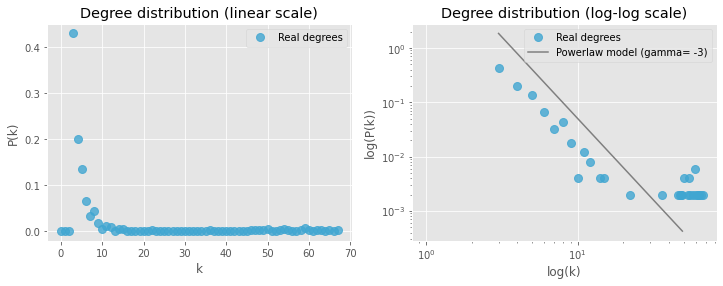

In [65]:
plt.figure(figsize=(12,4))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plot_distrib_lin(graph=G)
plt.subplot(1, 2, 2)
plot_distrib_log(graph=G, fit_line=True, expct_lo=3, expct_hi=50, expct_const=50)
plt.show()

## Community detection
One important aspect to deal with when analyzing network data is the identification of communities, i.e. clusters of nodes 'close' to each other according to some criteria. <br>
In the Complex Network theory there are many algorithms for performing community detection, which is a very hard and computationally expensive task. The different algorithms differ to each other depending on how they define the concept of cluster among nodes in a graph. <br>
We'll use some community detection algorithms implemented in the [networkx](https://networkx.org/documentation/stable/index.html#) python package and others implemented in [igraph](https://igraph.org/python/) for python.<br>
All the plots will be realized by using *networkx*, in order to have similar plots among the various partitions of each network.

In [66]:
# TODO

# Epidemic Spreading

## Monte Carlo simulation of SIS epidemic spreading
Monte Carlo simulation of an epidemic spreading dynamics in complex networks, using the SIS model in which each node represents an individual which can be in two possible states: 
* Susceptible (S), i.e., healthy but can get infected
* Infected (I), i.e., has the disease and can spread it to its neighbors.

We are interested in the calculation of the fraction of infected nodes, ρ, in the stationary state, as a function of the infection probability of the disease β, for different values of the recovery probability μ (e.g. 0.1, 0.5, 0.9). 

In [67]:
# TODO